## Brain network study during resting states
###  PROJECT part 1 (Neuroscience application)

<b><div style="text-align: right"> Omirbanu NURASSILOVA </div><b>
<div style="text-align: right"> Francesca PORCU </div> 
<div style="text-align: right"> Dusica STEPIC  </div>
<div style="text-align: right"> BIOINFORMATICS Class - Group 8   </div>
<div style="text-align: right">  November $25^{th}$, 2019 </div>

Goal of this project is to analyze two datasets of EEG data and to prepare a report on their comparison. EEG data are recorded from 64 electrodes with subject at rest in (i) eyes-open and (ii) eyes-closed conditions, respectively.

    Analyses will span the following topics:
    1. connectivity graphs
    2. graph theory indices
    3. motif analysis
    4. community detection 

## Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import connectivipy as cp
import random

import random
import pyedflib
from collections import defaultdict
import json

    installed packages
    !pip install connectivipy
    !pip install pyEDFlib
    !pip install networkx

In [2]:
file_name = 'S038R01.edf'  #eyes-open (EO)
file_name2 = 'S038R02.edf' #eyes-closed (EC)

#R01 is recorded during eyes-open (EO) resting state; R02 is recorded during eyes-closed (EC) resting state.

In [3]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    
    n = f.signals_in_file
    #signal_labels = f.getSignalLabels()
    signal_labels = [name.replace(".","") for name in f.getSignalLabels()]
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [4]:
labels, data = read_data_file(file_name)
labels2, data2 = read_data_file(file_name2)

# 1.1

1.1 (mandatory) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

https://connectivipy.readthedocs.io/en/latest/tutorial.html

In [5]:
len(labels)

64

In [6]:
def estimation_1(data, nrepp):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf_values = dt.conn('dtf')
    dtf_significance = dt.significance(Nrep=nrepp, alpha=0.05)
    return dtf_significance

In [7]:
def estimation_2(data, freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf = cp.conn.dtf_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return dtf

In [8]:
def estimation_3(data,freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    pdc = cp.conn.pdc_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return pdc

In [9]:
def find_T_est_1(significance,density): # i think our graph will be directed, 
    #but in case if it is undirected the we need to change formula
    total_num = significance.shape[0]*(significance.shape[1])
    k = significance.shape[0]
    n = int( density*total_num+k)
    T = sorted(significance.flatten())[-n]
    return T

In [10]:
def build_adj(est, T):
    adj = 1*(est>T)
    return adj

In [11]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [37]:
def build_graph(adj,labels):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    Edges = [(labels[idx_i[i]],labels[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    our_graph=nx.DiGraph()
    our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

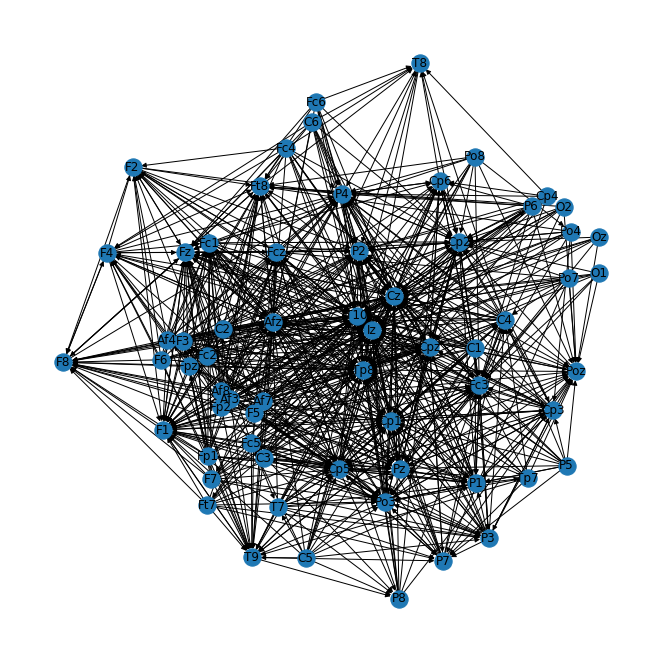

In [13]:
dtf= estimation_2(data,9)
T= find_T_est_1(dtf,0.2)
adjj= build_adj(dtf, T)
gg= build_graph(adjj,labels)

In [14]:
len(gg.edges)/(64*63)

0.20287698412698413

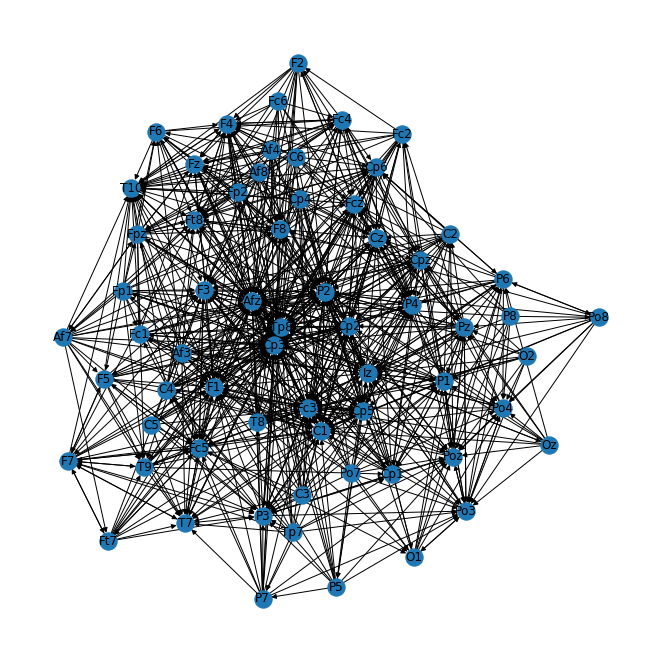

In [15]:
dtf2= estimation_2(data2,9)
T= find_T_est_1(dtf2,0.2)
adjj2= build_adj(dtf2, T)
gg2= build_graph(adjj2,labels2)

In [16]:
len(gg2.edges)/(64*63)

0.20287698412698413

# 1.2
(class ‘A’) Perform task 1.1 using both estimators (PDC and DTF).

False


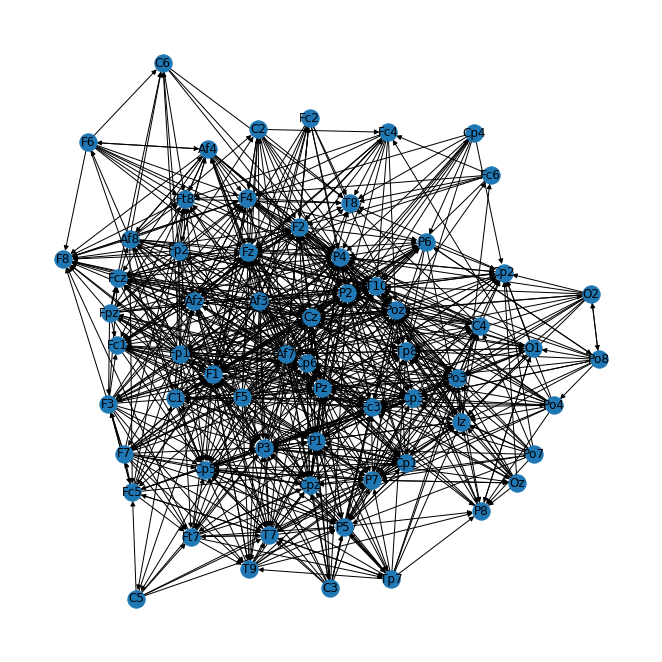

Name: 
Type: DiGraph
Number of nodes: 64
Number of edges: 818
Average in degree:  12.7812
Average out degree:  12.7812


In [17]:
pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.2)
adjj= build_adj(pdc, T)
print(check_symmetric(adjj))
gg3= build_graph(adjj,labels)
print (nx.info(gg3))

In [18]:
len(gg3.edges)/(64*63)

0.20287698412698413

False


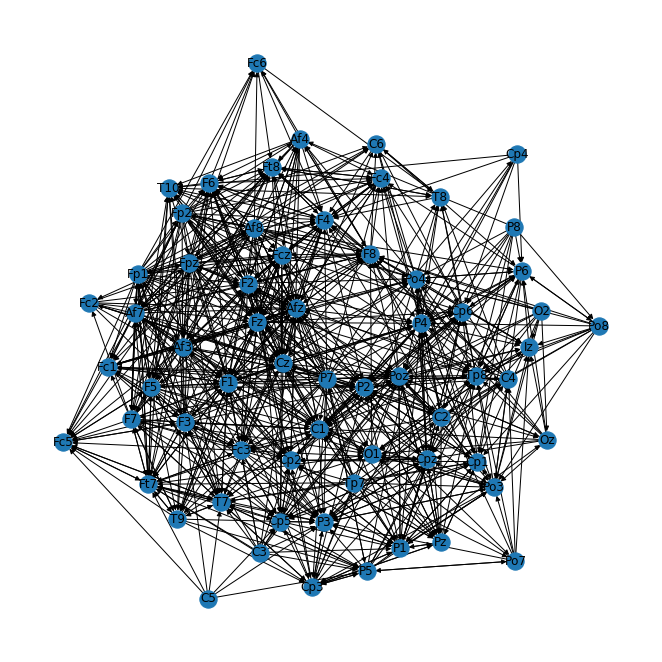

In [18]:
pdc2= estimation_3(data2,9) # second approach

T= find_T_est_1(pdc2,0.2)
adjj3= build_adj(pdc2, T)
print(check_symmetric(adjj3))
gg4= build_graph(adjj3,labels2)

In [20]:
len(gg4.edges)/(64*63)

0.20287698412698413

# 1.4.
(class ‘D’) Considering the subset of 19 channels suggested in Figure 1 and Table 2, estimate
the connectivity using PDC or DTF and apply a statistical validation method (asymptotic
statistics 7 , resampling procedure 8 ,...) to filter out values that are not significantly different
from 0 (PDC(i, j) ≠ 0 with p < 5%)

In [28]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels.index(sub_labels[i]) for i in range(19)]
sub_data = data[idx_labels,]

In [40]:
sign_19= estimation_1(sub_data, 100) # in this procedure is already specified alpha=0.05

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


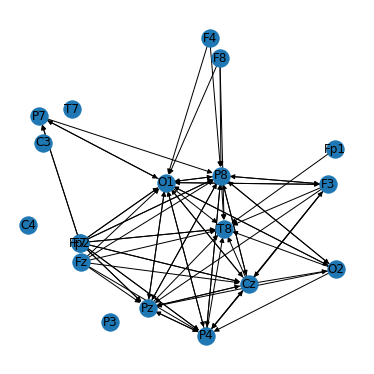

In [59]:
T= find_T_est_1(sign_19,0.2)
adjj19= build_adj(sign_19, T)
gg5= build_graph(adjj19,sub_labels)

In [60]:
len(gg5.edges)/(19*18)

0.20760233918128654

In [43]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels2.index(sub_labels[i]) for i in range(19)]
sub_data2 = data2[idx_labels,]

In [44]:
sign_19_2= estimation_1(sub_data2, 100) # in this procedure is already specified alpha=0.05

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


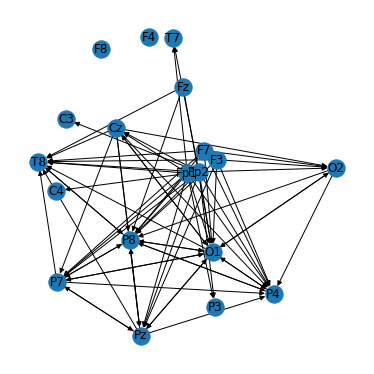

In [50]:
T= find_T_est_1(sign_19_2,0.2)
adjj19_2= build_adj(sign_19_2, T)
gg6= build_graph(adjj19_2,sub_labels)

In [51]:
len(gg6.edges)/(19*18)

0.20760233918128654

# 1.5.
(class ‘C’) Make a topographical representation of the networks (see example in Figure 2).
Cartesian coordinates of planar representation of EEG channels are available in Table 3 (see
also
the
file
channel_locations.txt).
(the choice of this task is advised in the case of 19-channel networks and/or density ≤ 5%).

In [19]:
#channel_locations.txt
chanel_locations = pd.read_table('channel_locations.txt', sep=' ', usecols=['label','x','y'])
chanel_locations['label']=chanel_locations['label'].str.replace('.','')

In [20]:
def build_graph_1_5(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

False


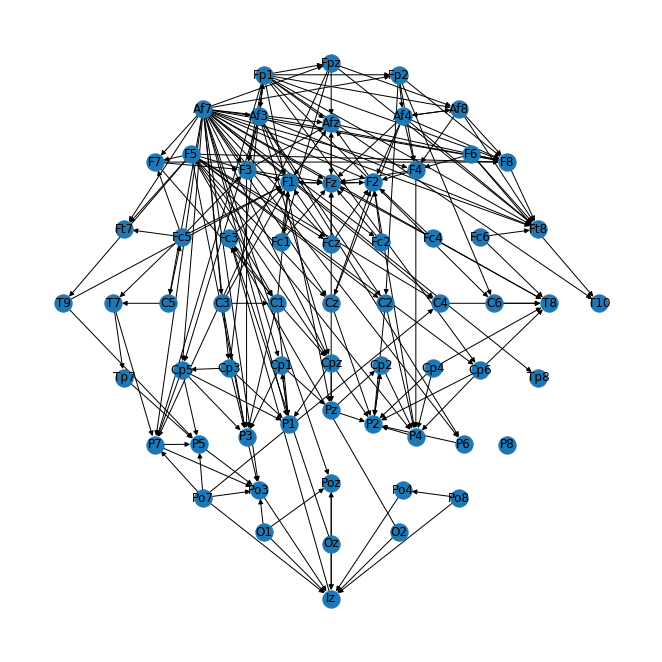

In [21]:
#pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.05)
adjj005= build_adj(pdc, T)
print(check_symmetric(adjj005))
gg7= build_graph_1_5(adjj005,labels,labels,chanel_locations)

False


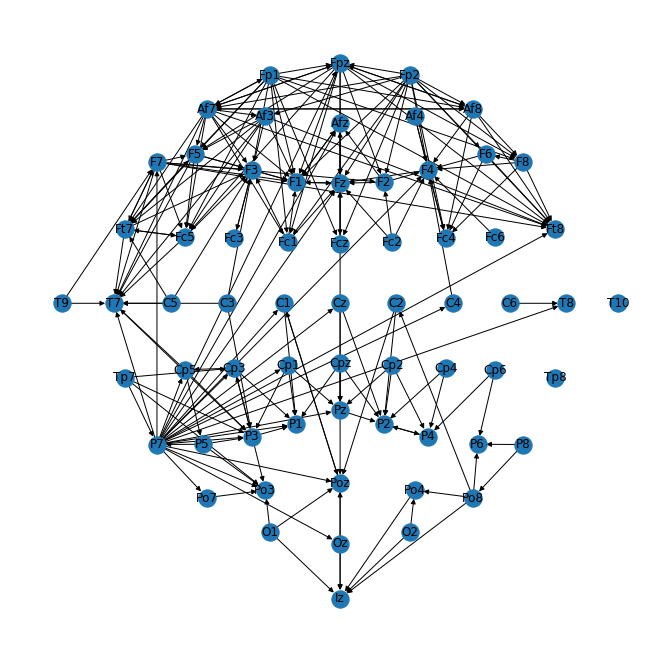

In [22]:
#pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc2,0.05)
adjj005= build_adj(pdc2, T)
print(check_symmetric(adjj005))
gg7_2= build_graph_1_5(adjj005,labels,labels,chanel_locations)

In [32]:
len(gg7.edges)/(64*63)

0.050347222222222224

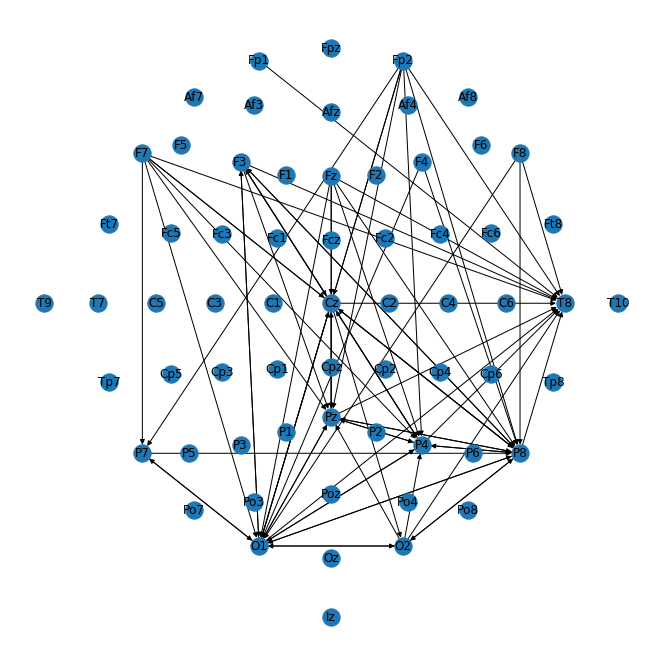

In [61]:
gg8= build_graph_1_5(adjj19,sub_labels,labels,chanel_locations)

In [56]:
len(gg8.edges)/(64*63)

0.017609126984126984

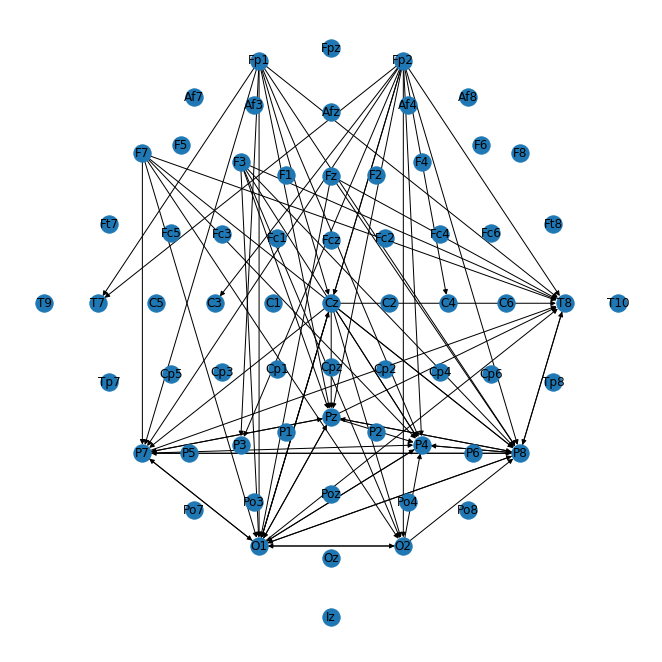

In [53]:
gg8_2= build_graph_1_5(adjj19_2,sub_labels,labels,chanel_locations)

In [57]:
len(gg8_2.edges)/(64*63)

0.017609126984126984

# 2.1
(mandatory) Compute binary global (clustering coefficient, path length) and local (degree,
in/out-degree) graph indices. List the highest 10 channels for local indices.


**The global/average clustering coefficient** of all the vertices $N$ in a *directed graph* is:
<br> $\overline{C_i} = \frac{1}{N} \sum_{i = 1}^{N} \frac{E_i}{k_i(k_i - 1)}$

where:
<br> $N$ is the number of nodes;
<br> $E_i$ is the number of edges among the neughbors:
<br> $k_i$ is the degree of a specific node.

In [17]:
#global clustering coefficient, is avg of CC among all nodes
def avg_CC(graph):
    CC=[]
    all_edg = set()
    for node in graph.nodes:
        #print(node)
        neighbors = (set(graph.successors(node))).union(set(graph.predecessors(node)))
        #print(neighbors)
        e=0
        neighbors.add(node)
        edges = set(graph.in_edges(node))
        edges= edges.union(set(graph.out_edges(node)))
        for ne in neighbors:
            edges= edges.union(set(graph.in_edges(ne)))
            edges = edges.union(set(graph.out_edges(ne)))
            
            #print("edges")
            #print(edges)
        for edg in edges:
            x, y = edg

            if (x in neighbors) and (y in neighbors):
                e=e+1
                    #print(1)
            #all_edg = all_edg.union(edges)
        #print(e)
        k = len(neighbors)*(len(neighbors)-1)
        #print(k)
        CC.append(e/(k))
    return np.sum(CC)/len(CC)

In [18]:
(avg_CC(gg)) #eyes-open (EO)

0.4096549614681534

In [19]:
(avg_CC(gg2)) #eyes-closed (EC)

0.41073416160929105

The **global/average path length** is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. We can calculate the average path length of a directed graph by using this following formula:

*l*<sub>G</sub> = $\frac{1}{n(n-1)}\sum_{i \neq j}d(v_{i}, v_{j})$

where $d(v_{i}, v_{j})$ represents the length of shortest path exists between two vertices and *_n_* the number of vertices in *G*. <br> So, we take sum of all shortest paths between all vertices and divide number of all possible paths.

In [25]:
#global/average path length
def avg_path(graph):
    l=[]
    for node in graph:
        # find all the descendants for each node
        descendants = set(nx.shortest_path_length(graph, node)) - set([node])
        e=0
        for x in descendants:
            # shortest path between two vertices
            s_p = nx.shortest_path_length(graph,source=node,target=x)
            e=e+s_p
        l.append(e)
        e_t = sum(l)
        k = len(graph.nodes())*(len(graph.nodes())-1)
    return (e_t/k)

In [26]:
#the average path length is:
avg_path(gg) #eyes-open (EO)

0.8432539682539683

In [22]:
avg_path(gg2) #eyes-closed (EC)

1.5562996031746033

In [23]:
#SHORTEST VERSION
def average_path(graph):
    return(nx.average_shortest_path_length(graph))

In [24]:
print(average_path(gg))

0.8432539682539683


The **degree** of a node *_i_* (*_i_* $\in [1, N], N$ number of nodes) is the total number of connections with other vertices. 
<br> The greater the degree, the more important is the presence of that node for the whole system.

In directed graph, the degree can be split into **in-degree** and **out-degree**: <br>

*In-degree* of node *_i_* is the total amount of links incoming to the vertex *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{in} = \sum_{j = 1, i \neq j}^{N} a_{ji}$, &nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{in}\in [0, N-1]$

*Out-degree* of node *_i_* is the total amount of links outgoing from the vertex *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{out} = \sum_{j = 1, i \neq j}^{N} a_{ij}$, &nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{out}\in [0, N-1]$

*Degree* of node *_i_* is the sum of incoming and outgoing degrees of node *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i} = k_{i}^{in} + k_{i}^{out}$

In [43]:
#in-degree
def in_degree(graph):
    in_d_10 = sorted(graph.in_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(in_d_10)

In [44]:
#highest 10 channels for in-degree 
in_degree(gg) #eyes-open (EO)

[('T10', 60),
 ('Iz', 60),
 ('Tp8', 56),
 ('Cz', 47),
 ('P2', 38),
 ('Cp2', 33),
 ('Cp1', 32),
 ('Fz', 30),
 ('Fc3', 29),
 ('Afz', 29)]

In [45]:
in_degree(gg2) #eyes-closed (EC)

[('Afz', 53),
 ('Cp3', 49),
 ('P2', 48),
 ('Tp8', 46),
 ('Fc3', 38),
 ('C1', 32),
 ('F1', 31),
 ('Iz', 28),
 ('T10', 26),
 ('Cp2', 25)]

In [46]:
#out-degree
def out_degree(graph):
    out_d_10 = sorted(graph.out_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(out_d_10)

In [47]:
#highest 10 channels for out-degree
out_degree(gg) #eyes-open (EO)

[('Cp5', 21),
 ('Afz', 20),
 ('Cp3', 19),
 ('Af7', 19),
 ('Fc5', 18),
 ('Fc3', 18),
 ('Fp1', 18),
 ('Fp2', 18),
 ('Af3', 18),
 ('F5', 18)]

In [48]:
out_degree(gg2) #eyes-closed (EC)

[('Cp3', 19),
 ('Fpz', 19),
 ('Af3', 19),
 ('Pz', 19),
 ('Fc5', 18),
 ('Fp1', 18),
 ('Afz', 18),
 ('P1', 17),
 ('Cp5', 16),
 ('Af7', 16)]

In [49]:
#degree
def degree(graph):
    d_10 = sorted(graph.degree(), key = lambda x: x[1], reverse = True)[:10]
    return(d_10)

In [50]:
#highest 10 channels for degree
degree(gg) #eyes-open (EO)

[('Iz', 68),
 ('Cz', 61),
 ('Tp8', 61),
 ('T10', 60),
 ('Cp5', 49),
 ('Cp1', 49),
 ('Afz', 49),
 ('Fc3', 47),
 ('P2', 46),
 ('Cp2', 44)]

In [51]:
degree(gg2) #eyes-closed (EC)

[('Afz', 71),
 ('Cp3', 68),
 ('P2', 62),
 ('Tp8', 52),
 ('Fc3', 51),
 ('C1', 46),
 ('Iz', 44),
 ('Cp2', 40),
 ('F1', 39),
 ('F3', 37)]

# 2.2

(class 'D') Search in the literature a definition of small-worldness index (i.e. an index describing the small-world organization of a network) and compute it.

A **small-world network** is a type of mathematical graph in which most nodes are not neighbors of one another, but the neighbors of any given node are likely to be neighbors of each other and most nodes can be reached from every other node by a small number of hops or steps. Specifically, a small-world network is defined to be a network where the typical distance L between two randomly chosen nodes (the number of steps required) grows proportionally to the logarithm of the number of nodes N in the network, while the clustering coefficient is not small.

A  graph G = (V, E) has a small-world property if it has a high  clustering coefficient and a small  characteristic path length. <br> - A *high  clustering coefficient* represents a local connectivity property, typically resulting in a high number of cliques and near-cliques, which denote subnetworks comprising edges between all or almost all vertices. 
<br> - A *small  characteristic path length* represents a global reachability property and roughly behaves logarithmic to the number of  graph vertices.

Small-world properties are found in many real-world phenomena, including websites, networks of brain neurons, voter networks, and social networks. 

In [52]:
#!pip install smallworld

In [53]:
from smallworld.draw import draw_network
from smallworld import get_smallworld_graph

In [107]:
def small_world(graph):
    #graph average degree
    degree_k = [item[1] for item in list(graph.in_degree)] 
    k_average = round(sum(degree_k)/len(degree_k))
    
    N = len(graph.nodes)
    k_over_2 = k_average//2
    betas = [0, 0.025, 1.0]
    labels_sw = [ r'Regular: $\beta=0$', r'Small-world: $\beta=0.025$', r'Random: $\beta=1$']
    
    focal_node = 0

    fig, ax = plt.subplots(1,3,figsize=(9,3))
    
    # scan beta values
    for ib, beta in enumerate(betas):

        # generate small-world graphs and draw
        G = get_smallworld_graph(N, k_over_2, beta)
        GD = G.to_directed()
        draw_network(GD,k_over_2,focal_node=focal_node,ax=ax[ib])
        print('Directed graph:', GD.is_directed())

        ax[ib].set_title(labels_sw[ib],fontsize=11)

    # show
    plt.subplots_adjust(wspace=0.3)
    plt.show()

Directed graph: True
Directed graph: True
Directed graph: True


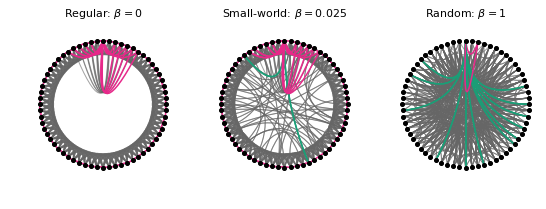

In [108]:
small_world(gg) #eyes-open (EO)

Directed graph: True
Directed graph: True
Directed graph: True


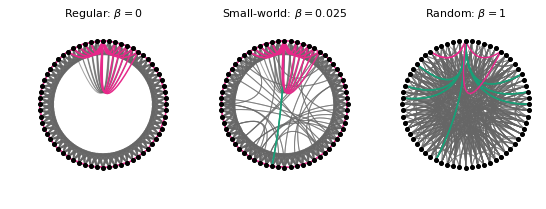

In [109]:
small_world(gg2) #eyes-closed (EC)

Network small-worldness has been quantified by a small-coefficient, $\sigma$, calculated by comparing clustering and path length of a given network to an equivalent random network with same degree on average.

$\sigma = \frac{\frac{C}{C_r}}{\frac{L}{L_r}}$

if $\sigma > 1$, network is small-world. However, this metric is known to perform poorly because it is heavily influenced by the network's size.

In [57]:
def small_world_sigma(graph):
    #create a directed random graph with same nodes and edges of our graph
    random_graph= nx.gnm_random_graph(len(graph.nodes), len(graph.edges), directed=True)
    
    #compare average clustering coefficients
    AC_sigma = avg_CC(graph)/avg_CC(random_graph)
    #compare average path lengths
    AP_sigma = avg_path(graph)/avg_path(random_graph)
    
    sigma = AC_sigma/AP_sigma
    
    return sigma

In [58]:
#omega>1 it is a small-world network
small_world_sigma(gg) #eyes-open (EO)

3.9017845819818207

In [59]:
small_world_sigma(gg2) #eyes-closed (EC)

2.1012342606436727

# 2.3

(class 'B') Compare the global indices extracted from PDC and DTF connectivity estimations.

In [60]:
#global clustering coefficient with PDC
avg_CC(gg3) #eyes-open (EO)

0.326237732581205

In [61]:
avg_CC(gg4) #eyes-closed (EC)

0.36055832554159606

In [62]:
#average path length with PDC
avg_path(gg3) #eyes-open (EO)

2.6731150793650795

In [63]:
avg_path(gg4) #eyes-closed (EC)

1.9871031746031746

# 2.5

(class 'B') Make a topographical representation of local indices.

In [64]:
def build_graph_degree(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    color_map = []
    for i in range(len(labels)):
        if i in [labels.index(nodes[i]) for i in range(10)]:
            color_map.append('blue')
        else:
            color_map.append('red')    
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,node_color = color_map,with_labels=True)
    plt.draw()
    plt.show()
    return our_graph

In [65]:
def local_indegree(graph):
    indegree_channels = [item[0] for item in list(in_degree(graph))]
    idx_indegree = [labels.index(indegree_channels[i]) for i in range(10)]
    sub_indegree = data[idx_indegree,]
    return indegree_channels, sub_indegree

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


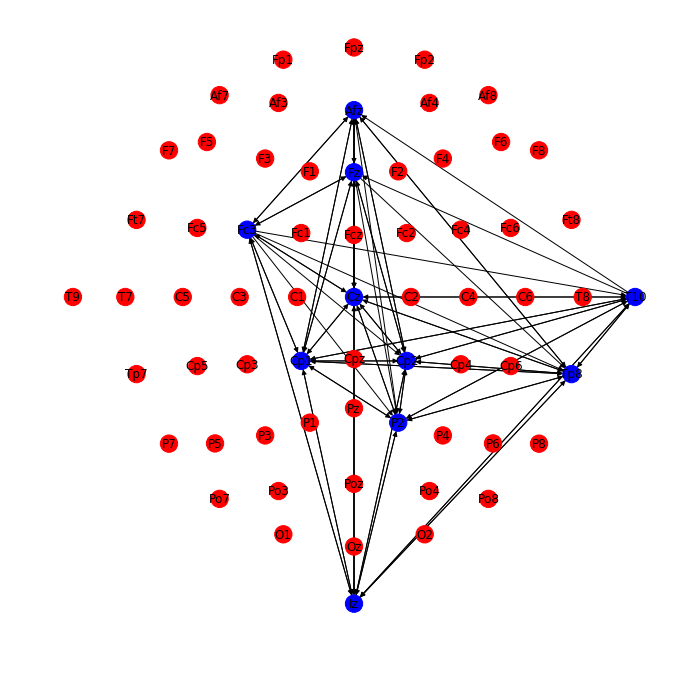

In [66]:
#eyes-open (EO)
#IN-DEGREE
ind_channels, s_indegree = local_indegree(gg)
indegree_est = estimation_2(s_indegree, 9)
T = find_T_est_1(indegree_est,0.80)
adjj_indegree = build_adj(indegree_est, T)
gg_local_indegree = build_graph_degree(adjj_indegree,ind_channels,labels,chanel_locations)

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


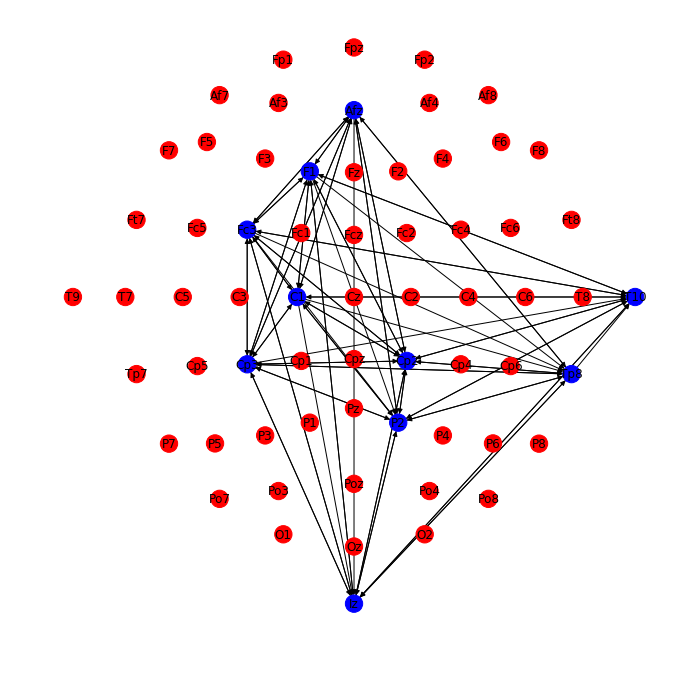

In [67]:
#eyes-closed (EC)
#IN-DEGREE
ind_channels, s_indegree = local_indegree(gg2)
indegree_est = estimation_2(s_indegree, 9)
T = find_T_est_1(indegree_est,0.80)
adjj_indegree = build_adj(indegree_est, T)
gg_local_indegree = build_graph_degree(adjj_indegree,ind_channels,labels,chanel_locations)

In [68]:
def local_outdegree(graph):
    outdegree_channels = [item[0] for item in list(out_degree(graph))]
    idx_outdegree = [labels.index(outdegree_channels[i]) for i in range(10)]
    sub_outdegree = data[idx_outdegree,]
    return outdegree_channels, sub_outdegree

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


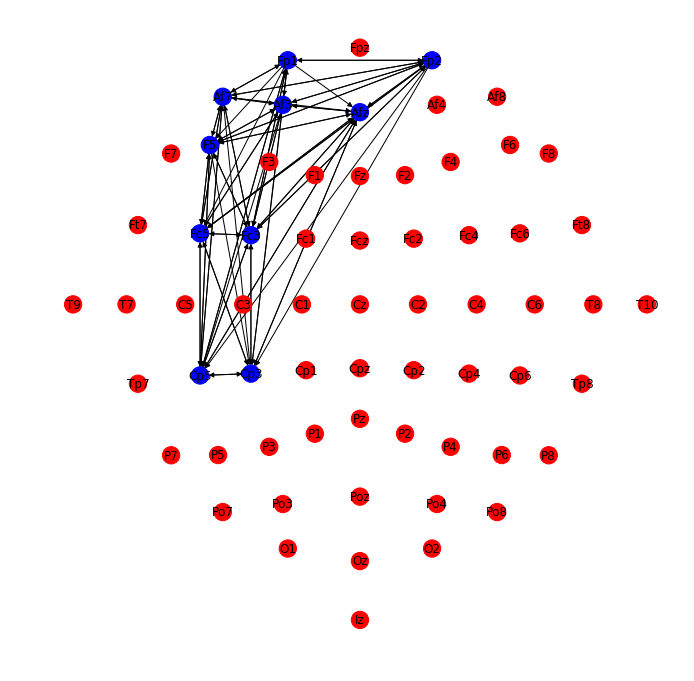

In [69]:
#eyes-open (EO)
#OUT-DEGREE
out_channels, s_outdegree = local_outdegree(gg)
outdegree_est = estimation_2(s_outdegree, 9)
T = find_T_est_1(outdegree_est,0.80)
adjj_outdegree= build_adj(outdegree_est, T)
gg_local_outdegree = build_graph_degree(adjj_outdegree,out_channels,labels,chanel_locations)

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


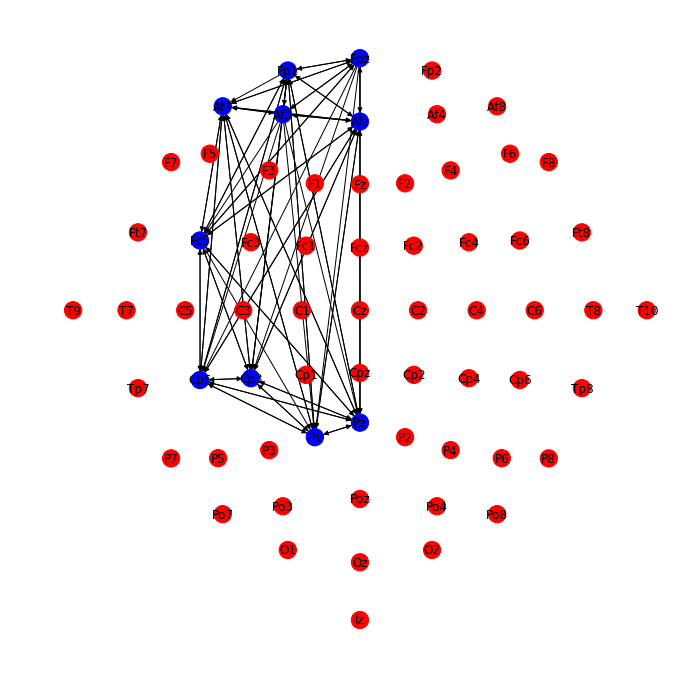

In [70]:
#eyes-closed (EC)
#OUT-DEGREE
out_channels, s_outdegree = local_outdegree(gg2)
outdegree_est = estimation_2(s_outdegree, 9)
T = find_T_est_1(outdegree_est,0.80)
adjj_outdegree= build_adj(outdegree_est, T)
gg_local_outdegree = build_graph_degree(adjj_outdegree,out_channels,labels,chanel_locations)

In [71]:
def local_degree(graph):
    degree_channels = [item[0] for item in list(degree(graph))]
    idx_degree = [labels.index(degree_channels[i]) for i in range(10)]
    sub_degree = data[idx_degree,]
    return degree_channels, sub_degree

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


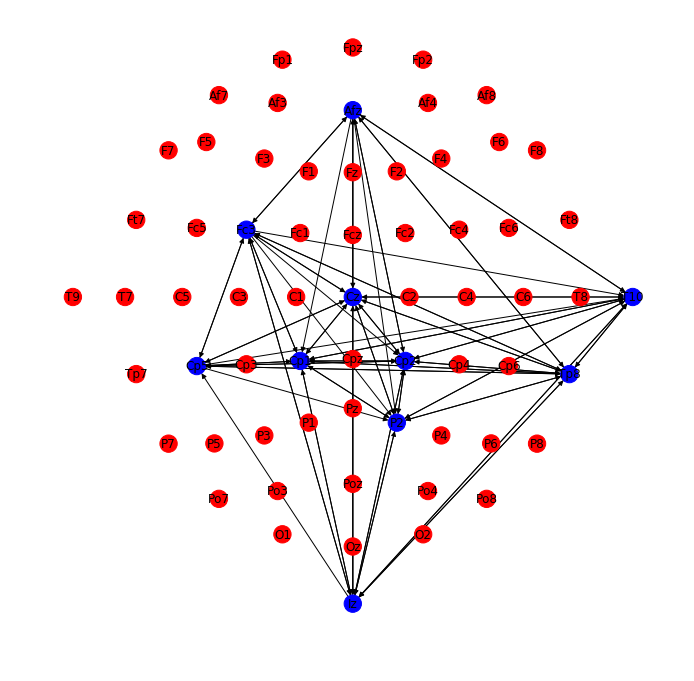

In [72]:
#eyes-open (EO)
#DEGREE
d_channels, s_degree = local_degree(gg)
degree_est = estimation_2(s_degree, 9)
T = find_T_est_1(degree_est,0.80)
adjj_degree= build_adj(degree_est, T)
gg_local_degree = build_graph_degree(adjj_degree,d_channels,labels,chanel_locations)

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


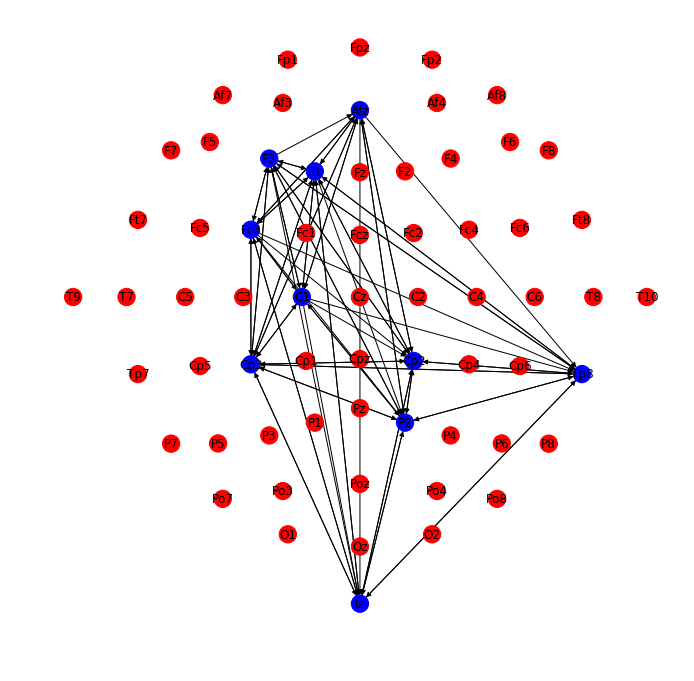

In [73]:
#eyes-closed (EC)
#DEGREE
d_channels, s_degree = local_degree(gg2)
degree_est = estimation_2(s_degree, 9)
T = find_T_est_1(degree_est,0.80)
adjj_degree= build_adj(degree_est, T)
gg_local_degree = build_graph_degree(adjj_degree,d_channels,labels,chanel_locations)

# 3.1.
(mandatory) Perform motifs analysis to investigate the presence of 3-node configurations in
the networks: determine their frequency and statistical significance (motifs, anti-motifs).

In [70]:
def get_freq(graph):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    #'A->B->C' #'A->B->C->A or A->B->C->B' # 'A->B->C->A->C' # A->B->C->A->C->B->A # A->B->C->B->A
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                if th!=node:
                    conf1.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    conf_6.add(tuple(sorted(set([node,sec,th,fourth,fi])) ))#(())
                        if fourth == node :
                            conf2.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    conf222.add(tuple(sorted(set([node,sec,th,fourth,fif]))))                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        conf_4.add(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    conf_5.add(tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                        if fourth==sec:
                            conf22.add(tuple(sorted(set([node,sec,th,fourth]))))
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    #pics.extend([conf1.pop(),conf2.pop(),conf22.pop(),conf222.pop(),conf_4.pop(),conf_5.pop()])
        #'A->B<-C' #'A->B<-C->A' or 'A->B<-C->A->C'
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf3.add(tuple(sorted(set([node,sec,th])) ))  
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            conf4.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    conf44.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    #pics.extend([conf3.pop(),conf4.pop(),conf44.pop()])
    # 'A<-B->C'  #'A<-B->C->B->A or A<-B->C->B'  # 'A<-B->C->A->C' 
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf5.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    conf8.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
                        if fourth==sec:
                            conf7.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    conf6.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    #pics.extend([conf5.pop(),conf6.pop(),conf7.pop(),conf8.pop()])
    #'A<-B->A->C->A->C''A<-B->A->C->A->C->B'
    #poss_confs['A<-B->A->C->A->C']=len(conf9)
    #poss_confs['A<-B->A->C->A->C->B']=len(conf10)
    return poss_confs#,pics

In [71]:
res= get_freq(gg)

In [72]:
res

{'A->B->C': [6536],
 'A->B->C->A': [376],
 'A->B->C->B': [2631],
 'A->B->C->A->C': [371],
 'A->B->C->A->C->B': [3883],
 'A->B->C->A->C->B->A': [58],
 'A->B->C->B->A': [355],
 'A->B<-C': [11879],
 'A->B<-C->A': [3660],
 'A->B<-C->A->C': [516],
 'A<-B->C': [4812],
 'A<-B->C->B': [900],
 'A<-B->C->A->C': [1040]}

In [73]:
64*63*62/6

41664.0

64!/(3!*61!) = 62*63*64/(6)

In [74]:
res2= get_freq(gg2)

In [75]:
res2

{'A->B->C': [7068],
 'A->B->C->A': [651],
 'A->B->C->B': [3356],
 'A->B->C->A->C': [616],
 'A->B->C->A->C->B': [7259],
 'A->B->C->A->C->B->A': [72],
 'A->B->C->B->A': [578],
 'A->B<-C': [9278],
 'A->B<-C->A': [3123],
 'A->B<-C->A->C': [649],
 'A<-B->C': [4475],
 'A<-B->C->B': [1367],
 'A<-B->C->A->C': [1191]}

In [76]:
def sub_graphs(results_dict):
    results=[x for x in results_dict.keys() if results_dict[x][0]>0]
    number_of_colors = 15
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    for i in range(len(results)):
        config = results[i]
        sub_graph = nx.DiGraph()
        sub_graph.add_nodes_from(['A','B','C'])
        for c  in range(len(config)):
            if config[c]=='>':
                sub_graph.add_edge(config[c-2],config[c+1])
            if config[c]=='<':
                sub_graph.add_edge(config[c+2],config[c-1])
        plt.figure(1,figsize=(2,2)) 
        nx.draw_networkx(sub_graph,node_color=random.choice(color),edge_color='b')
        plt.show()
        print(results_dict[config])


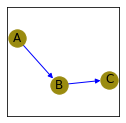

[6536]


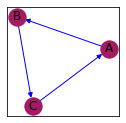

[376]


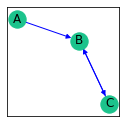

[2631]


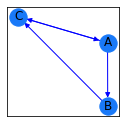

[371]


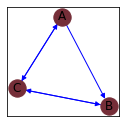

[3883]


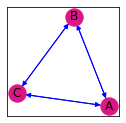

[58]


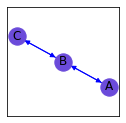

[355]


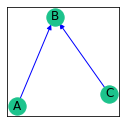

[11879]


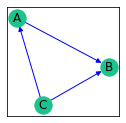

[3660]


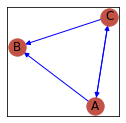

[516]


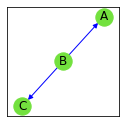

[4812]


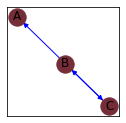

[900]


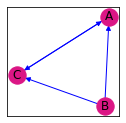

[1040]


In [91]:
sub_graphs(res)

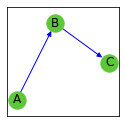

[7068]


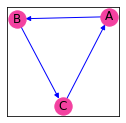

[651]


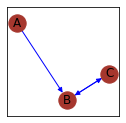

[3356]


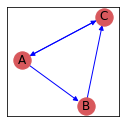

[616]


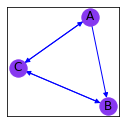

[7259]


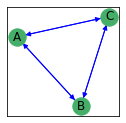

[72]


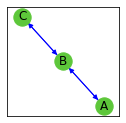

[578]


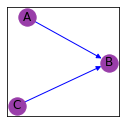

[9278]


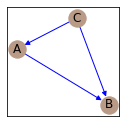

[3123]


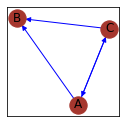

[649]


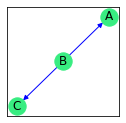

[4475]


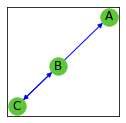

[1367]


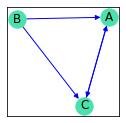

[1191]


In [78]:
sub_graphs(res2)

In [81]:
def rand_freq(dens):
    e =nx.erdos_renyi_graph(64,dens,directed=True)
    freq = get_freq(e)
    for i in range(100):
        e =nx.erdos_renyi_graph(64,dens,directed=True)
        first = get_freq(e)
        for x in first.keys():
            freq[x].append(first[x][0])
    freqmean_std=freq
    for f in freq.keys():
        freqmean_std[f]=(np.mean(freq[f]),np.std(freq[f]))
    return freqmean_std

In [82]:
r_g = rand_freq(0.2)
res= get_freq(gg)
res2 = get_freq(gg2)

In [83]:
def get_z(real, rand_g):
    result = {k: v for k, v in real.items()}
    for x in result.keys():
        div = (rand_g[x][1]+0.001)
        result[x]=(real[x][0]-rand_g[x][0])/(div)
    return result

In [84]:
get_z(res,r_g)

{'A->B->C': -3.8064424748999657,
 'A->B->C->A': -4.416641127172455,
 'A->B->C->B': 5.495147204042322,
 'A->B->C->A->C': 0.9791325789390524,
 'A->B->C->A->C->B': -0.6780542742109807,
 'A->B->C->A->C->B->A': 28.687481515361466,
 'A->B->C->B->A': 3.8315938886523164,
 'A->B<-C': 23.710388047475597,
 'A->B<-C->A': 14.029270688883594,
 'A->B<-C->A->C': 10.029188516877925,
 'A<-B->C': -0.03430264233501581,
 'A<-B->C->B': -3.8959385320032647,
 'A<-B->C->A->C': 25.199098880179463}

In [85]:
get_z(res2,r_g)

{'A->B->C': -2.6216877231356737,
 'A->B->C->A': -0.2593886089667169,
 'A->B->C->B': 9.414708415965164,
 'A->B->C->A->C': 6.208710749853545,
 'A->B->C->A->C->B': 3.7127962471709095,
 'A->B->C->A->C->B->A': 35.9362482885425,
 'A->B->C->B->A': 9.236089702412093,
 'A->B<-C': 14.976922376419509,
 'A->B<-C->A': 10.356379342956716,
 'A->B<-C->A->C': 14.218699023057642,
 'A<-B->C': -1.155877125675014,
 'A<-B->C->B': -1.3519526427421518,
 'A<-B->C->A->C': 29.71430133593482}

In [86]:
final_counts = pd.DataFrame(res).T
final_counts['1']=list(get_z(res,r_g).values())
final_counts.columns = ['N_real','Z']
final_counts

N_real          Z
A->B->C                6536  -3.806442
A->B->C->A              376  -4.416641
A->B->C->B             2631   5.495147
A->B->C->A->C           371   0.979133
A->B->C->A->C->B       3883  -0.678054
A->B->C->A->C->B->A      58  28.687482
A->B->C->B->A           355   3.831594
A->B<-C               11879  23.710388
A->B<-C->A             3660  14.029271
A->B<-C->A->C           516  10.029189
A<-B->C                4812  -0.034303
A<-B->C->B              900  -3.895939
A<-B->C->A->C          1040  25.199099

In [87]:
final_counts2 = pd.DataFrame(res2).T
final_counts2['1']=list(get_z(res2,r_g).values())
final_counts2.columns = ['N_real','Z']
final_counts2

N_real          Z
A->B->C                7068  -2.621688
A->B->C->A              651  -0.259389
A->B->C->B             3356   9.414708
A->B->C->A->C           616   6.208711
A->B->C->A->C->B       7259   3.712796
A->B->C->A->C->B->A      72  35.936248
A->B->C->B->A           578   9.236090
A->B<-C                9278  14.976922
A->B<-C->A             3123  10.356379
A->B<-C->A->C           649  14.218699
A<-B->C                4475  -1.155877
A<-B->C->B             1367  -1.351953
A<-B->C->A->C          1191  29.714301

In [89]:
final_counts.to_csv('1.csv')

In [90]:
final_counts2.to_csv('2.csv')

# 3.2
(class ‘C’) For the motif with pattern A → B ← C, create a topographical representation of the
networks considering only the connections involved in this configuration.

In [92]:
def func_3_2(graph):
    set_of_3 = set()
       
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                #set_of_3.add((node,sec,th))
                if th!=node:
                    set_of_3.add((node,sec))
                    set_of_3.add((th,sec))
                
    return set_of_3

In [94]:
edges = func_3_2(gg7)

In [95]:
def build_graph_3_2(edges,labels,coord):
    #idx_i, inx_j = np.where(adj==1)
    #idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = list(edges)#[(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

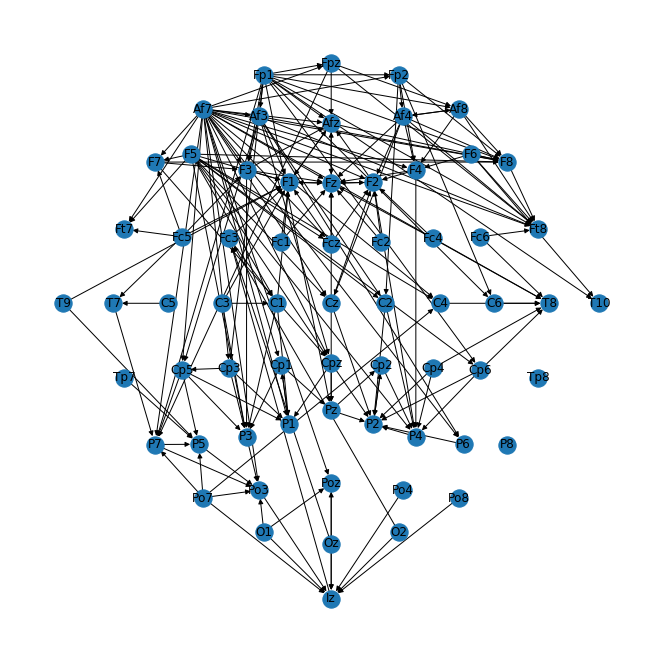

In [96]:
build_graph_3_2(edges,labels,chanel_locations)

In [97]:
len(edges)

193

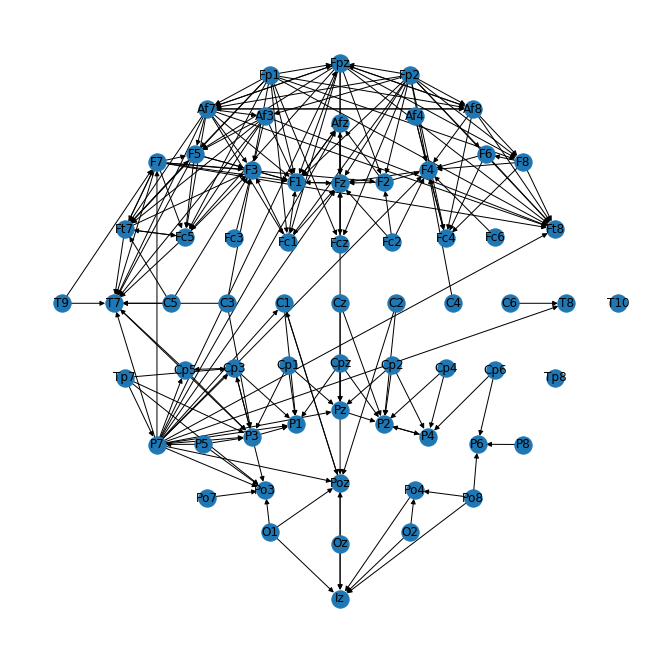

In [98]:
edges2 = func_3_2(gg7_2)
build_graph_3_2(edges2,labels,chanel_locations)

In [99]:
len(edges2)

193

In [97]:
len(gg.edges())

818

# 3.3
(class ‘C’) Choose a channel selected in parieto-occipital scalp region and determine the
motifs which involve it.

In [111]:
def get_freq_po(graph,po):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    #'A->B->C' #'A->B->C->A or A->B->C->B' # 'A->B->C->A->C' # A->B->C->A->C->B->A # A->B->C->B->A
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                t = (tuple(sorted(set([node,sec,th]))))
                if (po in t) and th!=node:
                    conf1.add(t)
                if node!=th:
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fi]))))
                                    if po in t:conf_6.add(t)
                        if fourth == node :
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t: conf2.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    t= (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf222.add(t)                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        t=(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if po in t:
                                            conf_4.add(t)
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    t= (tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                                                    if po in t:
                                                        conf_5.add(t)
                        if fourth==sec:
                            t= (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf22.add(t)
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    #pics.extend([conf1.pop(),conf2.pop(),conf22.pop(),conf222.pop(),conf_4.pop(),conf_5.pop()])
        #'A->B<-C' #'A->B<-C->A' or 'A->B<-C->A->C'
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf3.add(t)    
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            t=(tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf4.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf44.add(t)
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    #pics.extend([conf3.pop(),conf4.pop(),conf44.pop()])
    # 'A<-B->C'  #'A<-B->C->B->A or A<-B->C->B'  # 'A<-B->C->A->C' 
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf5.add(t)
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node and th!=node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf8.add(t)
                        if fourth==sec and th!=node:
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf7.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf6.add(t)
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    
    return poss_confs#,pics

In [112]:
motif_EO = list(final_counts[final_counts['Z']>1].index)

In [114]:
po8 =  get_freq_po(gg,'Po8')
subb={'1':[1]}
for x in motif_EO:
    subb[x]=po8[x]
del subb['1']

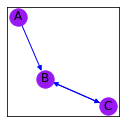

[43]


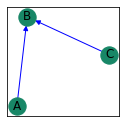

[369]


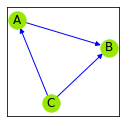

[45]


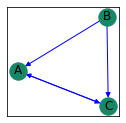

[11]


In [115]:
sub_graphs(subb)

{'A->B->C': [125], 'A->B->C->A': [4], 'A->B->C->B': [53], 'A->B->C->A->C': [4], 'A->B->C->A->C->B': [60], 'A->B->C->A->C->B->A': [0], 'A->B->C->B->A': [2], 'A->B<-C': [186], 'A->B<-C->A': [39], 'A->B<-C->A->C': [4], 'A<-B->C': [62], 'A<-B->C->B': [17], 'A<-B->C->A->C': [20]}


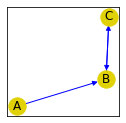

[53]


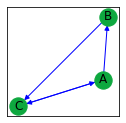

[4]


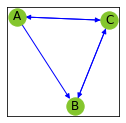

[60]


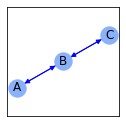

[2]


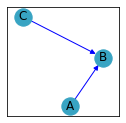

[186]


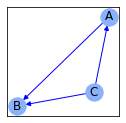

[39]


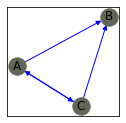

[4]


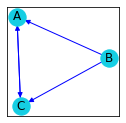

[20]


In [118]:
print(get_freq_po(gg2,'Po8'))
po8 =  get_freq_po(gg2,'Po8')
subb={'1':[1]}
motif_EC = list(final_counts2[final_counts2['Z']>1].index)
for x in motif_EC:
    subb[x]=po8[x]
del subb['1']
sub_graphs(subb)

{'A->B->C': [371], 'A->B->C->A': [14], 'A->B->C->B': [77], 'A->B->C->A->C': [14], 'A->B->C->A->C->B': [312], 'A->B->C->A->C->B->A': [0], 'A->B->C->B->A': [6], 'A->B<-C': [456], 'A->B<-C->A': [163], 'A->B<-C->A->C': [18], 'A<-B->C': [233], 'A<-B->C->B': [52], 'A<-B->C->A->C': [26]}


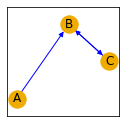

[77]


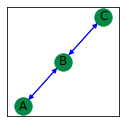

[6]


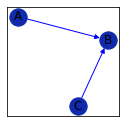

[456]


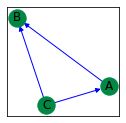

[163]


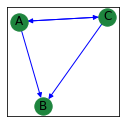

[18]


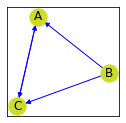

[26]


In [120]:
print(get_freq_po(gg,'Poz'))
poz =  get_freq_po(gg,'Poz')
subb={'1':[1]}
for x in motif_EO:
    subb[x]=poz[x]
del subb['1']
sub_graphs(subb)

{'A->B->C': [410], 'A->B->C->A': [47], 'A->B->C->B': [133], 'A->B->C->A->C': [41], 'A->B->C->A->C->B': [661], 'A->B->C->A->C->B->A': [8], 'A->B->C->B->A': [23], 'A->B<-C': [327], 'A->B<-C->A': [164], 'A->B<-C->A->C': [42], 'A<-B->C': [255], 'A<-B->C->B': [105], 'A<-B->C->A->C': [57]}


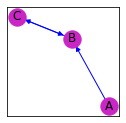

[133]


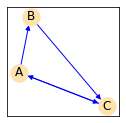

[41]


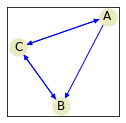

[661]


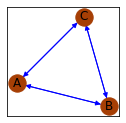

[8]


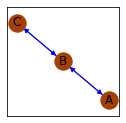

[23]


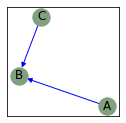

[327]


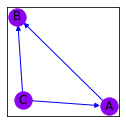

[164]


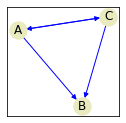

[42]


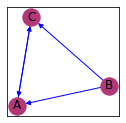

[57]


In [121]:
print(get_freq_po(gg2,'Poz'))
po8 =  get_freq_po(gg2,'Poz')
subb={'1':[1]}
motif_EC = list(final_counts2[final_counts2['Z']>1].index)
for x in motif_EC:
    subb[x]=po8[x]
del subb['1']
sub_graphs(subb)

In [106]:
import igraph
from igraph import *
from igraph import Graph as igraphGraph
#random.seed(13)

DeprecationWarning: To avoid name collision with the igraph project, this visualization library has been renamed to 'jgraph'. Please upgrade when convenient.

'''
Steps to install igraph on windows woth python 3.7

https://www.lfd.uci.edu/~gohlke/pythonlibs/#python-igraph


download dependencies from the website and put them in the folder

pycairo first ? with your version of windows 32/64 and python version(my case 3.7)
pip install pycairo-1.18.1-cp37-cp37m-win32.whl

type in anaconda prompt
(base) C:\Users\dusic>pip install pycairo-1.18.2-cp37-cp37m-win_amd64.whl

(base) C:\Users\dusic>pip install python_igraph-0.7.1.post6-cp37-cp37m-win_amd64.whl

(base) C:\Users\dusic>pip install louvain-0.6.1-cp37-cp37m-win_amd64.whl

'''

## 4. Community detection

    - 4.1. (mandatory) Determine number and composition (i.e. list of nodes) of the communities obtained applying one of the algorithms introduced during the course.
    - 4.2. (class ‘B’) Make a graphical representation of the community structure in both rest conditions.
    - 4.3. (class ‘C’) Compare the community structure obtained by means of two different methods (modularity-based vs information theory-based approaches).

## Information theory-based approach --> INFOMAP

In [ ]:
random.seed(13)  

In [ ]:
chanel_locations['coord']=chanel_locations.apply(lambda row: (row.x,row.y),axis=1)
positions=pd.Series(chanel_locations.coord.values,index=chanel_locations.label).to_dict()
m={k:v for k,v in enumerate(labels)}

In [ ]:
def callme(gr,file_name=''):
    ##I way to put it as a file and read it as igraph 
  # nx.write_graphml(grr,'graph.graphml') # Export NX graph to file
  #  i_g = igraph.read('graph.graphml',format="graphml") 
  #  i_g.vs["name"] = list(grr.nodes())


    ##II way to convert networkx to igraph
    i_g = igraphGraph(directed=True)
    i_g.add_vertices(list(gr.nodes()))
    i_g.add_edges(gr.edges())
    i_g.vs["name"] = list(gr.nodes())
    
    count_dict=defaultdict(int)
    cl=i_g.community_infomap()
    res=dict(zip(i_g.vs["name"],cl.membership))
    for k,v in res.items():
        count_dict[v]+=1
##    print(count_dict)
    count_dict2=defaultdict(list)
    for k,v in res.items():
        count_dict2[v].append(k)
    
    fn='infomap_'+file_name
    with open(fn, 'w') as f:
        json.dump(count_dict2, f)
     
    df=pd.DataFrame.from_dict(count_dict,orient='index')
    
##    df=df.sort_index()
##    print(cl.modularity)
    x='*'*35
    print(x,'\n','NUMBER OF COMMUNITIES','---------->',len(count_dict2.keys()),'\n',x)
    print(df,'\n',x)
    print('Composition of the communities ',count_dict2)
    plotCommInfoMap(i_g,count_dict2,fn)
    return i_g,cl,count_dict2

In [ ]:
def plotCommInfoMap(graph,composition,plt_title):
    g=graph
    
    color_dict={}
    number_of_colors = len(composition.keys())
    palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    G = nx.from_edgelist([(names[x[0]], names[x[1]])
                          for names in [g.vs['name']] # simply a let
                          for x in g.get_edgelist()], nx.DiGraph())
    for k,v in composition.items():
        color=palette[k]
        for node in composition[k]:
            if node in G.nodes():
                color_dict[node]=color
    color_map=[color_dict[k] for k in G.nodes()]
        
    plt.figure(3,figsize=(9,9))
    plt.title(plt_title)
    
    nx.draw(G,node_color=color_map,with_labels=True,pos=positions,node_size=450)
    plt.savefig(plt_title+'.png')

In [ ]:
def read_file(file_name):
    with open(file_name,'r') as f:
        file = json.load(f)
    return file

In [ ]:
graph, community,composition = callme(gg,'EO')

In [ ]:
graph, community,composition = callme(gg2,'EC')

In [ ]:
### JUST TESTING IF infomap method will color differently different clusters??

In [ ]:
graph, community,composition = callme(gg7,'EO different graph testing')

## Modularity-based approach --> The Louvain algorithm

The Louvain algorithm is one of the fastest modularity-based algorithms, and works well with large graphs.

In [ ]:
import louvain

In [ ]:
def callmeMB(gr,file_name=''):
    i_g = igraphGraph(directed=True)
    i_g.add_vertices(list(gr.nodes()))
    i_g.add_edges(gr.edges())
    i_g.vs["name"] = list(gr.nodes())
    
    count_dict=defaultdict(int)
    cl = louvain.find_partition(i_g, louvain.ModularityVertexPartition)

    res=dict(zip(i_g.vs["name"],cl.membership))
    for k,v in res.items():
        count_dict[v]+=1
##    print(count_dict)
    count_dict2=defaultdict(list)
    for k,v in res.items():
        count_dict2[v].append(k)
    
    fn='louvain_'+file_name
    with open(fn, 'w') as f:
        json.dump(count_dict2, f)
     
    df=pd.DataFrame.from_dict(count_dict,orient='index')
    
##    df=df.sort_index()
##    print(cl.modularity)
    x='*'*35
    print(x,'\n','NUMBER OF COMMUNITIES','---------->',len(count_dict2.keys()),'\n',x)
    print(df,'\n',x)
    print('Composition of the communities ',count_dict2)
    plotCommInfoMap(i_g,count_dict2,fn)
    return i_g,cl,count_dict2

In [ ]:
graph, community,composition = callmeMB(gg,'EO')

In [ ]:
graph, community,composition = callmeMB(gg2,'EC')

### Leicht & Newman Algorithm

In [ ]:
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity

In [ ]:
def callmeMB2(gr,file_name=''):
    res = partition(gr)
    count_dict=defaultdict(int)
    for k,v in res.items():
        count_dict[v]+=1
##    print(count_dict)
    count_dict2=defaultdict(list)
    for k,v in res.items():
        count_dict2[v].append(k)
    
    fn='Leicht & Newman_'+file_name
    with open(fn, 'w') as f:
        json.dump(count_dict2, f)
     
    df=pd.DataFrame.from_dict(count_dict,orient='index')
 
    x='*'*35
    print(x,'\n','NUMBER OF COMMUNITIES','---------->',len(count_dict2.keys()),'\n',x)
    print(df,'\n',x)
    print('Composition of the communities ',count_dict2)

    

    color_dict={}
    number_of_colors = len(composition.keys())
    palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    
    
    for k,v in composition.items():
        color=palette[k]
        for node in composition[k]:
            if node in gr.nodes():
                color_dict[node]=color
    color_map=[color_dict[k] for k in gr.nodes()]
        
    plt.figure(3,figsize=(9,9))
    plt.title(fn)
    
    nx.draw(gr,node_color=color_map,with_labels=True,pos=positions,node_size=350)
    plt.savefig(fn+'.png')
    return 

In [ ]:
callmeMB2(gg,'EO')

In [ ]:
callmeMB2(gg2,'EC')